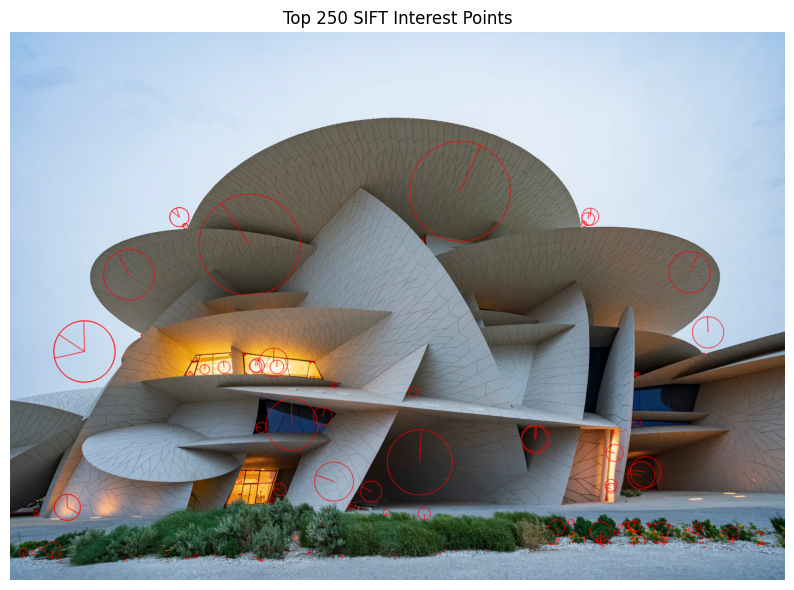

In [4]:
#task1 : Interest point detection

import cv2
import numpy as np
import matplotlib.pyplot as plt

image_path = 'building.webp'
image = cv2.imread(image_path)

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

sift = cv2.SIFT_create()

keypoints, descriptors = sift.detectAndCompute(gray, None)

keypoints = sorted(keypoints, key=lambda x: -x.response)

N = 250
keypoints = keypoints[:N]

output = cv2.drawKeypoints(image, keypoints, None, color=(0, 0, 255), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
plt.title(f"Top {N} SIFT Interest Points")
plt.axis("off")
plt.show()


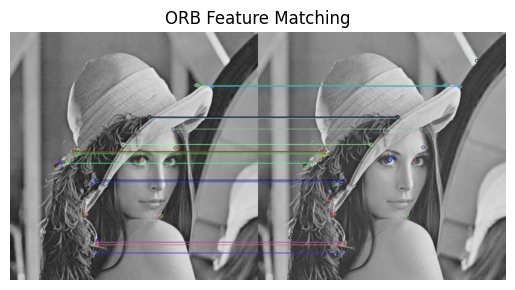

In [7]:
import cv2
import matplotlib.pyplot as plt

img1 = cv2.imread('Lena_Image.jpg', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('Lena_Image.png', cv2.IMREAD_GRAYSCALE)

# ORB detector with reduced number of keypoints
orb = cv2.ORB_create(nfeatures=86)
kp1, des1 = orb.detectAndCompute(img1, None)
kp2, des2 = orb.detectAndCompute(img2, None)

# BFMatcher
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1, des2)
matches = sorted(matches, key=lambda x: x.distance)


matched_image = cv2.drawMatches(img1, kp1, img2, kp2, matches[:20], None)


plt.imshow(matched_image)
plt.title("ORB Feature Matching")
plt.axis('off')
plt.show()


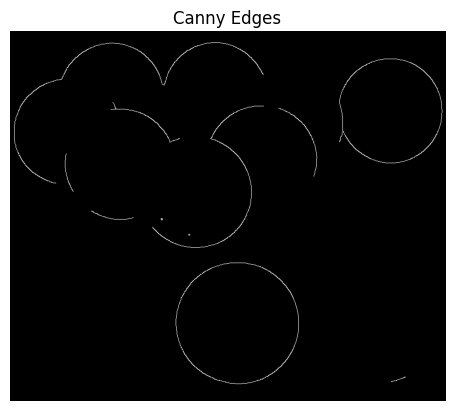

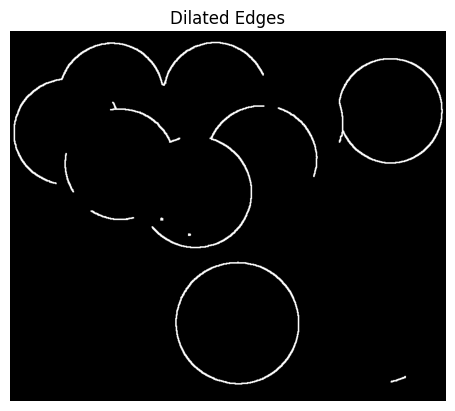

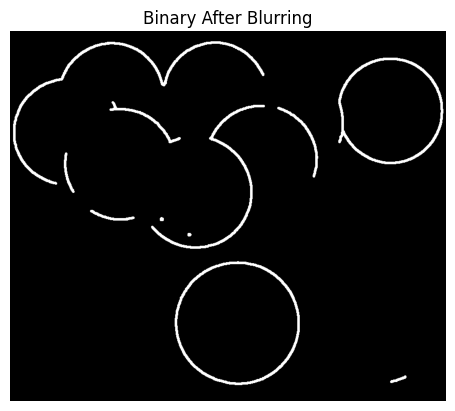

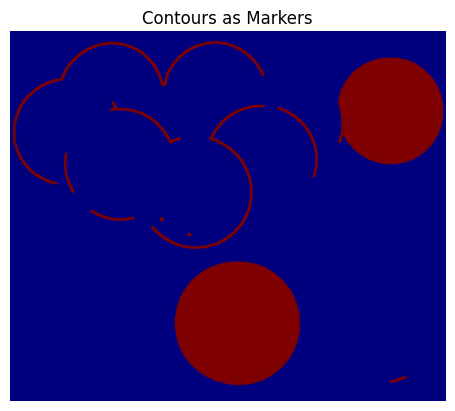

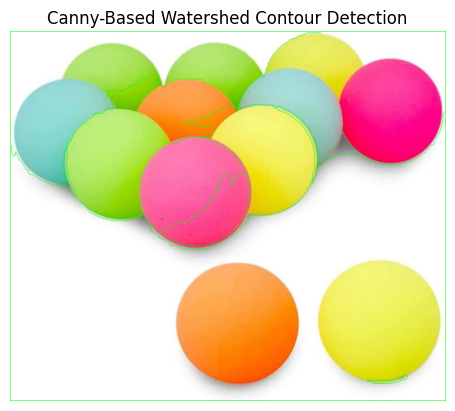

In [8]:
#task : Contour detection

import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread('balls.webp')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Edge detection
edges = cv2.Canny(gray, 100, 200)

plt.imshow(edges, cmap='gray')
plt.title("Canny Edges")
plt.axis('off')
plt.show()

# Dilation to strengthen edges
kernel = np.ones((3, 3), np.uint8)
edges_dilated = cv2.dilate(edges, kernel, iterations=1)

plt.imshow(edges_dilated, cmap='gray')
plt.title("Dilated Edges")
plt.axis('off')
plt.show()

# Smooth and binarize
blurred = cv2.GaussianBlur(edges_dilated, (5, 5), 0)
ret, binary = cv2.threshold(blurred, 50, 255, cv2.THRESH_BINARY)

plt.imshow(binary, cmap='gray')
plt.title("Binary After Blurring")
plt.axis('off')
plt.show()

# Find and draw contours
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
markers = np.zeros_like(gray)
cv2.drawContours(markers, contours, -1, 255, -1)

plt.imshow(markers, cmap='jet')
plt.title("Contours as Markers")
plt.axis('off')
plt.show()

# Watershed segmentation
markers = cv2.connectedComponentsWithStats(markers.astype(np.uint8))[1]
markers = cv2.watershed(img, markers)
img[markers == -1] = [0, 255, 0]

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Canny-Based Watershed Contour Detection")
plt.axis('off')
plt.show()


In [9]:
#task 2.1 : Resnet

import time
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import matplotlib.pyplot as plt

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load CIFAR-100 Dataset
trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

# Define training function
def train_model(model, epochs=3):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses = []
    start_time = time.time()

    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_loss = running_loss / len(trainloader)
        train_losses.append(avg_loss)
        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

    end_time = time.time()
    print(f"Training Time: {end_time - start_time:.2f} seconds")
    return train_losses, model

# Evaluation function
def evaluate_model(model):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    accuracy = 100 * correct / total
    print(f"Accuracy: {accuracy:.2f}%")
    return accuracy

# Load ResNet18
resnet18 = models.resnet18(pretrained=True)
resnet18.fc = nn.Linear(resnet18.fc.in_features, 100)

# Load ResNet34
resnet34 = models.resnet34(pretrained=True)
resnet34.fc = nn.Linear(resnet34.fc.in_features, 100)

print("\nTraining ResNet18...")
loss18, model18 = train_model(resnet18)
acc18 = evaluate_model(model18)

print("\nTraining ResNet34...")
loss34, model34 = train_model(resnet34)
acc34 = evaluate_model(model34)


plt.plot(loss18, label='ResNet18 Loss')
plt.plot(loss34, label='ResNet34 Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Comparison')
plt.legend()
plt.show()


print(f"\nComparison:\nResNet18 Accuracy: {acc18:.2f}%\nResNet34 Accuracy: {acc34:.2f}%")


Files already downloaded and verified
Files already downloaded and verified


/opt/homebrew/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/ankit/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 36.4MB/s]
/opt/homebrew/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and


Training ResNet18...


Epoch 1, Loss: 2.8742
Epoch 2, Loss: 2.1257


[E thread_pool.cpp:130] Exception in thread pool task: mutex lock failed: Invalid argument


KeyboardInterrupt: 